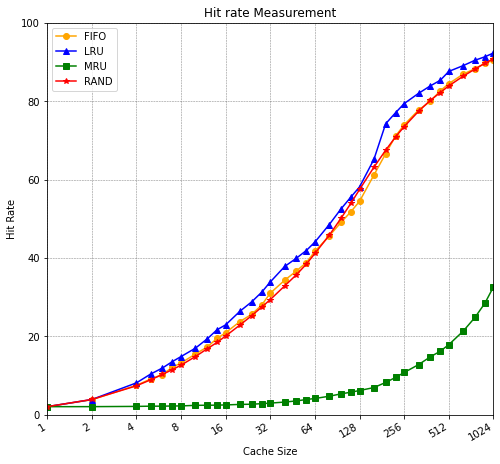

In [1]:
%matplotlib inline

import os
import re
import subprocess
import tempfile

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter
from typing import List


def generate_trace() -> List[int]:
  # Define the command you want to run
  command = ["valgrind", "--tool=lackey", "--trace-mem=yes", "ls", "~"]
  try:
    # Run the command and capture the output
    result = subprocess.run(command, stderr=subprocess.PIPE)

    pattern = '^ [MLS ] ([0-9a-fA-F]+),'
    matches = re.findall(pattern, result.stderr.decode(), re.MULTILINE)

    page_size = 4096
    trace = [str(int(addr, base=16) % page_size) for addr in matches]
    return trace

  except subprocess.CalledProcessError as e:
    print("An error occurred while running the command: ", command)
    print(e.stderr)
    os.exit(1)

xmax = 10

# Create the plot
plt.figure(figsize=(8, 8))
plt.title('Hit rate Measurement')
plt.xlabel('Cache Size')
plt.ylabel('Hit Rate')
plt.axhline(0, color='black',linewidth=0.5, ls='--')  # Add x-axis
plt.axvline(0, color='black',linewidth=0.5, ls='--')  # Add y-axis
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)  # Add grid
plt.xlim(1, xmax+1)
plt.ylim(0, 100)
plt.xscale('log', base=2)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1)) # Place tick marks at every multiple of 1, i.e. at any integer
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: int(x))) # Format the tick label to be 2 raised to the power of `x`
plt.gcf().autofmt_xdate() # Make the axis labels rotated for easier reading
plt.xticks([2 ** i for i in range(xmax+1)])

def calc_hit_rate(policy: str, cache_size: int, address_file: str) -> float:
  # Define the command you want to run
  command = ["./paging-policy.py", "--policy", policy,  "--cachesize", str(cache_size), "--addressfile", address_file, "-c"]
  try:
    # Run the command and capture the output
    result = subprocess.run(command, stdout=subprocess.PIPE)

    pattern = 'hitrate (.+)'
    match = re.search(pattern, result.stdout.decode(), re.MULTILINE)
    return float(match.group(1))

  except subprocess.CalledProcessError as e:
    print("An error occurred while running the command: ", command)
    print(e.stderr)
    os.exit(1)

cache_sizes = [2 ** i for i in range(xmax + 1)]
for end_pow in range(3, xmax + 1):
  end = 2 ** end_pow
  start, step = end // 2, end // 8
  cache_sizes.extend(range(start, end, step))
cache_sizes = sorted(set(cache_sizes))

policies = ['FIFO', 'LRU', 'MRU', 'RAND']
colors = ['orange', 'blue', 'green', 'red']
markers = "o^s*"

with tempfile.NamedTemporaryFile('w+') as address_file:
  traces = generate_trace()
  address_file.write('\n'.join(traces))
  for i in range(len(policies)):
    policy, color, marker = policies[i], colors[i], markers[i]
    hit_rates = [calc_hit_rate(policy, cache_size, address_file.name) for cache_size in cache_sizes]
    # print(f'{policy}: {[(x, y) for x, y in zip(cache_sizes, hit_rates)]}')
    x, y = cache_sizes, hit_rates
    plt.plot(x, y, label=f'{policy}', color=color, marker=marker) # Plot the line

plt.legend()
plt.show()